グラフの文字に日本語が使っているため、最初はエラーがでていた。日本語フォントのIPAexフォントをインストール、更にキャッシュをクリアして、何とか出るようになった。

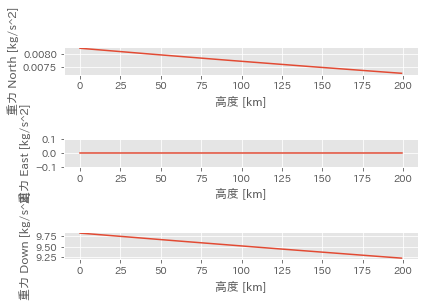

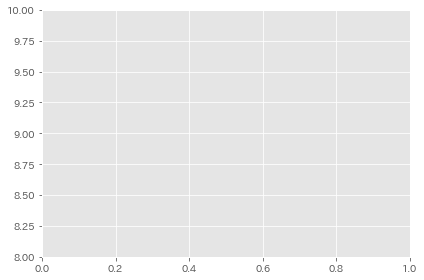

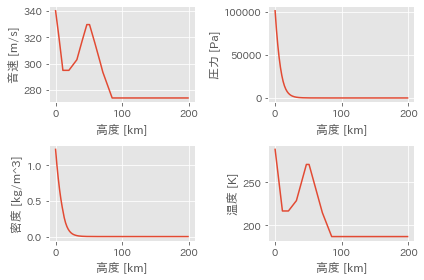

In [1]:
%matplotlib inline
"""
環境（大気、重力）関連の計算関数

Copyright (c) 2016 Kenji Nakakuki
Released under the MIT license
"""

from collections import namedtuple
import numpy as np
from numpy import exp, sqrt, sin

# 定数の設定
AtomConst = namedtuple('AtomConst',
                       ['g',  # 重力定数
                        'gamma',  # 比熱比
                        'gas_cnst',  # 気体乗数
                        'hal',  # table: Height of atmospheric layer
                        'lr',  # table: Lapse Rate Kelvin per meter
                        't0',  # table: Tempareture Kelvin
                        'p0'  # table: Pressure
                        ])
GravConst = namedtuple('GravConst',
                       ['mu',  # Earth's gravitational constant [m^3/s^2]
                        'radi_e',  # 地球半径(at some latitude?)
                        'j2',  # Jeffery constant J2
                        'epsilon'  # 扁平率
                        ])

ac = AtomConst(9.80665, 1.4, 287.0531,
               np.array([0, 11000, 20000, 32000, 47000, 51000, 71000, 84852]),
               np.array([-0.0065, 0.0, 0.001, 0.0028, 0.0,
                         -0.0028, -0.002, 0.0]),
               np.array([288.15, 216.65, 216.65, 228.65, 270.65,
                         270.65, 214.65, 186.95]),
               np.array([101325, 22632, 5474.9, 868.02, 110.91,
                         66.939, 3.9564, 0.3734]))
gc = GravConst(3.986004e14, 6378135.0, 1.08263e-3, 1 / 298.257)


def std_atmosphere(alt):
    """標準大気モデルを用いた、高度による温度、音速、大気圧、空気密度の関数

    高度は基準ジオポテンシャル高度。標準大気の各層ごとの気温減率から定義式を用いて計算。
    Standard Atmosphere 1976　ISO 2533:1975
    中間圏高度86kmまでの気温に対応している。それ以上は国際標準大気に当てはまらないので注意。

    引数:
        alt : ジオポテンシャル高度 [m]

    返り値: as list
        a : 音速 [m/s]
        press : 圧力 [Pa]
        rho : 密度 [km/m^3]
        temp : 温度 [K]
    """
    # TODO : ATOMOSPHERIC and SPACE FLIGHT DYNAMICSより
    # TODO : Standard ATOMOSPHEREのスクリプトに変更して高度2000kmまで対応にする。

    k = (ac.hal >= alt).argmax()

    if ac.hal[0] >= alt:
        k = 0
    elif ac.hal[7] <= alt:
        k = 7
    elif k >= 1:
        k -= 1
    else:
        raise ValueError("Index value error")

    # 温度
    temp = ac.t0[k] + ac.lr[k] * (alt - ac.hal[k])
    # 音速
    a = sqrt(temp * ac.gamma * ac.gas_cnst)
    # 圧力
    if ac.lr[k] != 0:
        press = ac.p0[k] * ((ac.t0[k] + ac.lr[k] * (alt - ac.hal[k])) /
                             ac.t0[k]) ** (-ac.g / ac.lr[k] / ac.gas_cnst)
    else:
        press = ac.p0[k] * exp(ac.g / ac.gas_cnst *
                                (ac.hal[k] - alt) / ac.t0[k])
    # 密度
    rho = press / ac.gas_cnst / temp
    return [a, press, rho, temp]


def gravity(alt, lat):
    """重力を計算する

    地球を自転軸回りの回転楕円体と仮定し、Jefferyの帯球係数を第2項まで考慮した
    重力加速度を求める。遠心力は考慮していないので、地面固定の重力加速度と比較すると
    小さな値が出力される。

    引数:
        alt : 高度 [m]
        lat : 緯度 [rad]

    返り値 :
        重力ベクトル（ndarray） (NED座標)
            gnorth : North方向重力加速度 [m/^s2]
            gdown : Down方向重力加速度 [m/s^2]
    """
    r = alt + gc.radi_e * (1 - gc.epsilon * sin(lat) ** 2)
    gdown = gc.mu / r ** 2 * (1 - 1.5 * gc.j2 * (gc.radi_e / r) ** 2 *
                              (3 * sin(lat) ** 2 - 1))
    gnorth = gc.mu / r ** 2 * gc.j2 * (gc.radi_e / r) ** 2 * sin(2 * lat)

    return np.array([gnorth, 0.0, gdown])


# 動作確認用
if __name__ == '__main__':
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    # Matplotlibの設定
    plt.style.use('ggplot')
    mpl.rcParams['figure.autolayout'] = True
    mpl.rcParams['font.family'] = 'IPAexGothic'
    mpl.rcParams['axes.grid'] = True

    # 重力計算関数の確認
    alt = np.arange(0, 200000, 1000)
    alt_km = alt * 1.e-3  # plot用に単位変換しておく
    grav = np.zeros((len(alt), 3))
    for i, h in enumerate(alt):
        grav[i, :] = gravity(h, 35)  # 北緯 35度で計算

    # 開いてあるプロットを一端全部閉じる
    plt.close('all')

    # 重力計算結果のプロット
    plt.figure(1)
    plt.subplot(3, 1, 1)
    plt.plot(alt_km, grav[:, 0])
    plt.xlabel('高度 [km]')
    plt.ylabel('重力 North [kg/s^2]')
    plt.subplot(3, 1, 2)
    plt.plot(alt_km, grav[:, 1])
    plt.xlabel('高度 [km]')
    plt.ylabel('重力 East [kg/s^2]')
    plt.ylim([-0.1, 0.1])
    plt.subplot(3, 1, 3)
    plt.plot(alt_km, grav[:, 2])
    plt.xlabel('高度 [km]')
    plt.ylabel('重力 Down [kg/s^2]')
    plt.show()
    plt.ylim([8, 10])

    # 大気計算関数の確認
    atmos = np.zeros((len(alt), 4))
    for k, h in enumerate(alt):
        atmos[k, :] = std_atmosphere(h)

    # 標準大気計算結果のプロット
    plt.figure(2)
    plt.subplot(2, 2, 1)
    plt.plot(alt_km, atmos[:, 0])
    plt.xlabel('高度 [km]')
    plt.ylabel('音速 [m/s]')
    plt.subplot(2, 2, 2)
    plt.plot(alt_km, atmos[:, 1])
    plt.xlabel('高度 [km]')
    plt.ylabel('圧力 [Pa]')
    plt.subplot(2, 2, 3)
    plt.plot(alt_km, atmos[:, 2])
    plt.xlabel('高度 [km]')
    plt.ylabel('密度 [kg/m^3]')
    plt.subplot(2, 2, 4)
    plt.plot(alt_km, atmos[:, 3])
    plt.xlabel('高度 [km]')
    plt.ylabel('温度 [K]')
